Load package dependencies for vehicle detection


In [1]:
import pickle
import cv2
import glob
import time
import numpy as np

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

%matplotlib inline

load trainning set cut off by 10k

In [2]:
# Load training data files
def load_training_set(size=10000):
    trainning_vehicles = glob.glob('vehicles/*/*.png')[0:size]
    training_non_vehicles = glob.glob('non-vehicles/*/*.png')[0:size]
    print(len(trainning_vehicles), len(training_non_vehicles))
    return trainning_vehicles, training_non_vehicles

car_images,noncar_images = load_training_set()
print(len(car_images), len(noncar_images))

8792 8968
8792 8968


copy from cource material,  use all hog channels

In [3]:
#copy over configs from material
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

copy from course material, get hog features, extra features for all tranning images

In [4]:
def get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

8792 8968


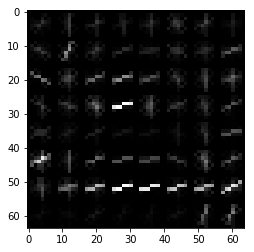

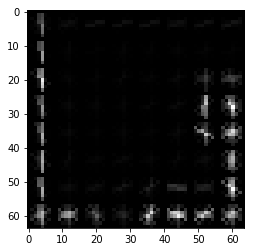

In [5]:
trainning_vehicles, training_non_vehicles = load_training_set()
v_image = mpimg.imread(trainning_vehicles[0])
n_v_image = mpimg.imread(training_non_vehicles[0])

vehicle_feature, vehicle_hog_image = get_hog_features(v_image[:,:,2],vis=True, feature_vec=True)
non_vehicle_feature, non_vehicle_hog_image = get_hog_features(n_v_image[:,:,2], vis=True, feature_vec=True)

#Plot vehicle and hog feature
fig = plt.figure()
plt.imshow(v_image)
plt.imshow(vehicle_hog_image, cmap='gray')

#Plot non vehicle and hog feature
fig = plt.figure()
plt.imshow(n_v_image)
plt.imshow(non_vehicle_hog_image, cmap='gray')

In [6]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

58.5 Seconds to extract HOG features


In [7]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.27 Seconds to train SVC...
Test Accuracy of SVC =  0.982
SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.00161 Seconds to predict 10 labels with SVC


In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions, copy over
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

Number of boxes:  129


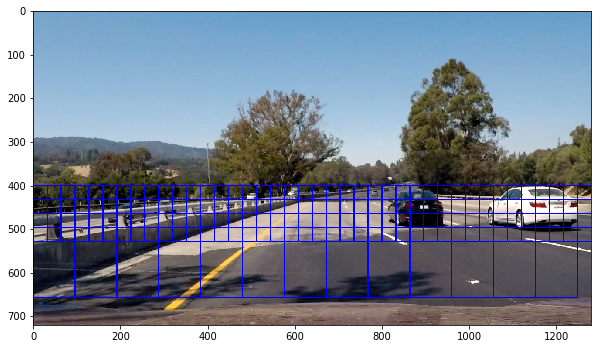

In [9]:
test_img = mpimg.imread('./test_images/test4.jpg')
rects = []

ystart = 400
ystop = 550
scale = 1.0
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

ystart = 464
ystop = 660
scale=3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))


4 rectangles found in image


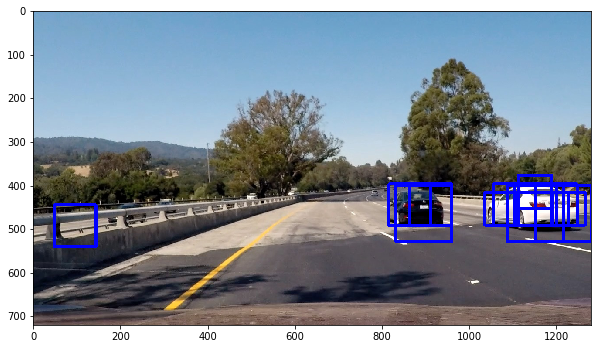

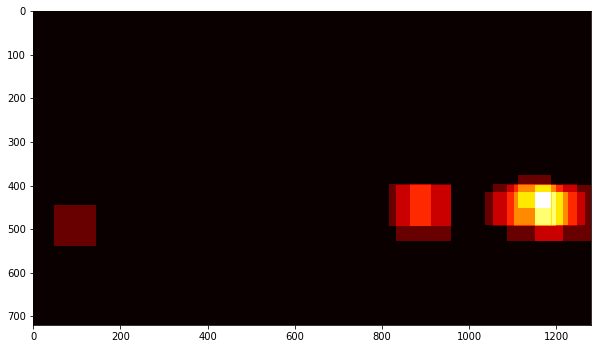

In [10]:
test_img = mpimg.imread('./test_images/test4.jpg')
rects = []

#apply multi windows of various scales
rects.append(find_cars(test_img, 300, 500, 1.2, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
rects.append(find_cars(test_img, 300, 550, 1.5, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
rects.append(find_cars(test_img, 400, 600, 2.0, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
rects.append(find_cars(test_img, 460, 660, 3.5, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

print(len(rects), 'rectangles found in image')
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

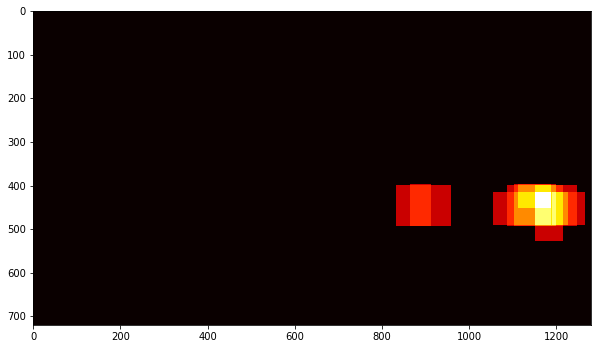

In [11]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = apply_threshold(add_heat(heatmap_img, rectangles), 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


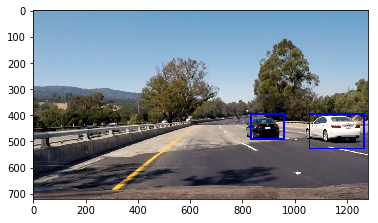

In [12]:
from scipy.ndimage.measurements import label
labels = label(heatmap_img)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap_img, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

plt.imshow(draw_img, cmap='gray')

In [13]:
def process_frame(test_img, threshold=1):
    rects = []

    #apply multi windows of various scales
    rects.append(find_cars(test_img, 300, 550, 1.2, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    rects.append(find_cars(test_img, 300, 550, 1.5, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    rects.append(find_cars(test_img, 400, 600, 2.0, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    rects.append(find_cars(test_img, 460, 660, 3.5, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

    print(len(rects), 'rectangles found in image')
    rectangles = [item for sublist in rects for item in sublist] 
    test_img_rects = draw_boxes(test_img, rectangles)
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = apply_threshold(add_heat(heatmap_img, rectangles), threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap_img, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(test_img), labels)

4 rectangles found in image
4 rectangles found in image
4 rectangles found in image
4 rectangles found in image
4 rectangles found in image
4 rectangles found in image


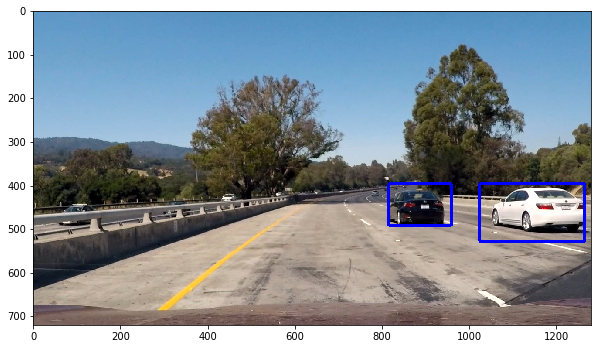

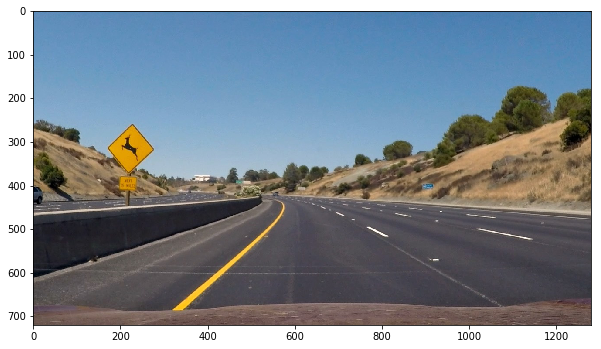

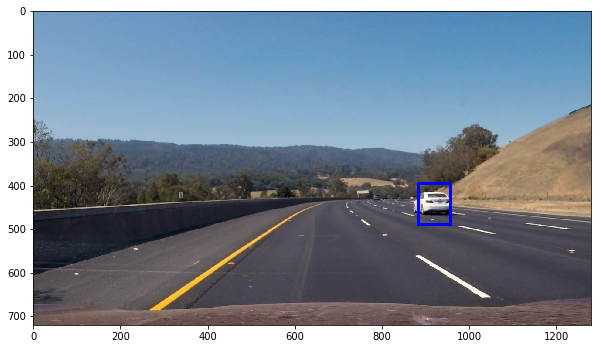

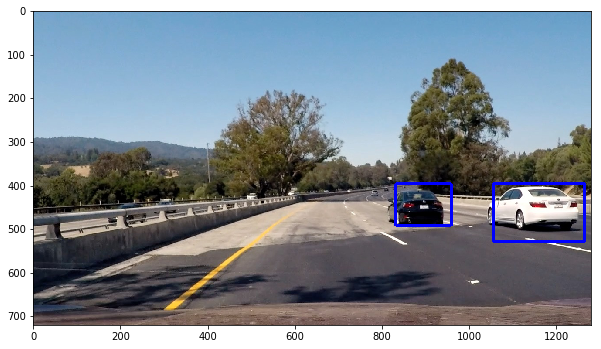

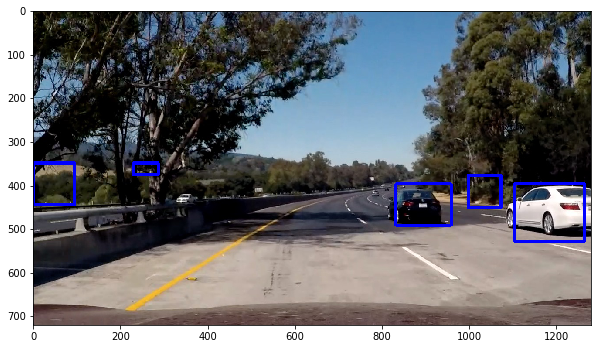

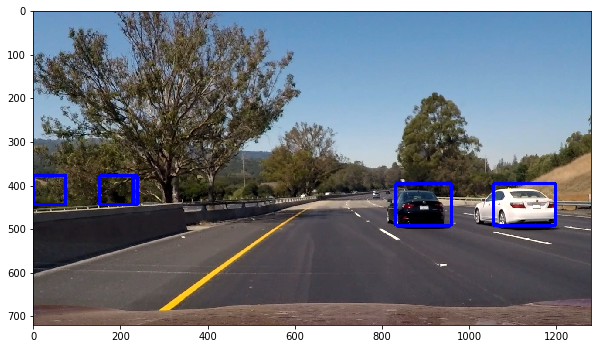

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(process_frame(mpimg.imread('./test_images/test1.jpg')), cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(process_frame(mpimg.imread('./test_images/test2.jpg')), cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(process_frame(mpimg.imread('./test_images/test3.jpg')), cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(process_frame(mpimg.imread('./test_images/test4.jpg')), cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(process_frame(mpimg.imread('./test_images/test5.jpg')), cmap='gray')
plt.figure(figsize=(10,10))
plt.imshow(process_frame(mpimg.imread('./test_images/test6.jpg')), cmap='gray')

In [15]:
test_result_file = 'test_result.mp4'
test_result = VideoFileClip('test_video.mp4').fl_image(process_frame)
test_result.write_videofile(test_result_file, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_result_file))

4 rectangles found in image
[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


  3%|▎         | 1/39 [00:00<00:20,  1.82it/s]

4 rectangles found in image


  5%|▌         | 2/39 [00:01<00:19,  1.92it/s]

4 rectangles found in image


  8%|▊         | 3/39 [00:01<00:18,  1.95it/s]

4 rectangles found in image


 10%|█         | 4/39 [00:01<00:16,  2.15it/s]

4 rectangles found in image


 13%|█▎        | 5/39 [00:02<00:14,  2.30it/s]

4 rectangles found in image


 15%|█▌        | 6/39 [00:02<00:13,  2.40it/s]

4 rectangles found in image


 18%|█▊        | 7/39 [00:02<00:12,  2.48it/s]

4 rectangles found in image


 21%|██        | 8/39 [00:03<00:12,  2.43it/s]

4 rectangles found in image


 23%|██▎       | 9/39 [00:03<00:11,  2.52it/s]

4 rectangles found in image


 26%|██▌       | 10/39 [00:04<00:12,  2.32it/s]

4 rectangles found in image


 28%|██▊       | 11/39 [00:04<00:12,  2.29it/s]

4 rectangles found in image


 31%|███       | 12/39 [00:05<00:12,  2.24it/s]

4 rectangles found in image


 33%|███▎      | 13/39 [00:05<00:11,  2.20it/s]

4 rectangles found in image


 36%|███▌      | 14/39 [00:05<00:10,  2.41it/s]

4 rectangles found in image


 38%|███▊      | 15/39 [00:06<00:09,  2.53it/s]

4 rectangles found in image


 41%|████      | 16/39 [00:06<00:08,  2.67it/s]

4 rectangles found in image


 44%|████▎     | 17/39 [00:06<00:07,  2.77it/s]

4 rectangles found in image


 46%|████▌     | 18/39 [00:07<00:08,  2.42it/s]

4 rectangles found in image


 49%|████▊     | 19/39 [00:07<00:08,  2.42it/s]

4 rectangles found in image


 51%|█████▏    | 20/39 [00:08<00:07,  2.58it/s]

4 rectangles found in image


 54%|█████▍    | 21/39 [00:08<00:06,  2.59it/s]

4 rectangles found in image


 56%|█████▋    | 22/39 [00:09<00:06,  2.65it/s]

4 rectangles found in image


 59%|█████▉    | 23/39 [00:09<00:06,  2.42it/s]

4 rectangles found in image


 62%|██████▏   | 24/39 [00:09<00:06,  2.50it/s]

4 rectangles found in image


 64%|██████▍   | 25/39 [00:10<00:05,  2.62it/s]

4 rectangles found in image


 67%|██████▋   | 26/39 [00:10<00:04,  2.67it/s]

4 rectangles found in image


 69%|██████▉   | 27/39 [00:10<00:04,  2.74it/s]

4 rectangles found in image


 72%|███████▏  | 28/39 [00:11<00:03,  2.82it/s]

4 rectangles found in image


 74%|███████▍  | 29/39 [00:11<00:03,  2.67it/s]

4 rectangles found in image


 77%|███████▋  | 30/39 [00:12<00:03,  2.48it/s]

4 rectangles found in image


 79%|███████▉  | 31/39 [00:12<00:03,  2.45it/s]

4 rectangles found in image


 82%|████████▏ | 32/39 [00:13<00:02,  2.35it/s]

4 rectangles found in image


 85%|████████▍ | 33/39 [00:13<00:02,  2.31it/s]

4 rectangles found in image


 87%|████████▋ | 34/39 [00:13<00:02,  2.33it/s]

4 rectangles found in image


 90%|████████▉ | 35/39 [00:14<00:01,  2.26it/s]

4 rectangles found in image


 92%|█████████▏| 36/39 [00:14<00:01,  2.27it/s]

4 rectangles found in image


 95%|█████████▍| 37/39 [00:15<00:00,  2.25it/s]

4 rectangles found in image


 97%|█████████▋| 38/39 [00:15<00:00,  2.33it/s]

4 rectangles found in image


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

